# Evaluation
 
Now that we have our pipelines developed, embeddings done, chunks optimized and created, we can evaluate its performance. You can do it with the code below, but I'll directly load the results. 

Please note that due to my own sloppiness, I ran several different evaluations and saved them to different csv's. I aggregated the results together into a csv. 

In [1]:
import ,sys
from pathlib import Path
sys.path.append(Path(__file__).parent.parent)

from run_evaluation import EvaluationConfig, EvaluationRunner

config = EvaluationConfig(
    num_questions=300,
    target_tokens=150,
    overlap_tokens=50,
    hard_ceiling=500,
    methods=["rag", "reranked_rag", "ensemble_rerank_rag", "unfiltered", "web_search", "baseline"],
    k_values=[1, 3, 5, 7, 10],
)

runner = EvaluationRunner(config)
runner.run()
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
from pathlib import Path

from eval_utils import get_cost, load_data

root_dir = Path(os.getcwd()).parent   

df = pd.read_csv(root_dir / 'data' / 'results' / 'final' / 'consolidated_results_fixed_tokens.csv')
df['cost'] = df.apply(get_cost, axis=1)
df.head()

,question,ground_truth_answer,generated_answer,system,rrf_enabled,adj_mrr,adj_recall@1,adj_recall@10,adj_recall@3,adj_recall@5,...,rouge1,rouge2,rougeL,section,ticker,tokens,total_tokens,year,source_file,cost
0,What is the interest payment schedule for the ...,Interest on the Notes issued in 2012 is payabl...,The interest payment schedule for the Notes is...,rag,False,NaN,NaN,NaN,NaN,NaN,...,0.576923,0.400000,0.576923,NaN,NaN,"{'prompt_tokens': 1705, 'completion_tokens': 4...",NaN,NaN,evaluation_results_20250621_111538_with_bleu_n...,0.000282
1,Which company did the company acquire in 2012?,"In 2012, the company acquired Instagram, Inc. ...","In 2012, META (Facebook) acquired Instagram in...",rag,False,0.0,0.0,0.0,0.0,0.0,...,0.250000,0.086957,0.250000,7,META,NaN,NaN,2012.0,evaluation_results_20250622_002251_enhanced.csv,0.000246
2,What was the anticipated range of shares Mark ...,Mark Zuckerberg anticipated selling 35 million...,The provided context does not contain any info...,rag,False,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.043478,0.166667,9B,META,NaN,NaN,2018.0,evaluation_results_20250622_002251_enhanced.csv,0.000246
3,What was the anticipated range of shares Mark ...,Mark Zuckerberg anticipated selling 35 million...,The provided context does not contain any info...,reranked_rag,False,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.043478,0.166667,9B,META,NaN,NaN,2018.0,evaluation_results_20250622_002251_enhanced.csv,0.000241
4,What was the anticipated range of shares Mark ...,Mark Zuckerberg anticipated selling 35 million...,The context does not provide information regar...,ensemble_rerank_rag,False,0.0,0.0,0.0,0.0,0.0,...,0.432432,0.057143,0.216216,9B,META,NaN,NaN,2018.0,evaluation_results_20250622_002251_enhanced.csv,0.000191


Let's look at the distributions of Bleu-4 and Rouge-L

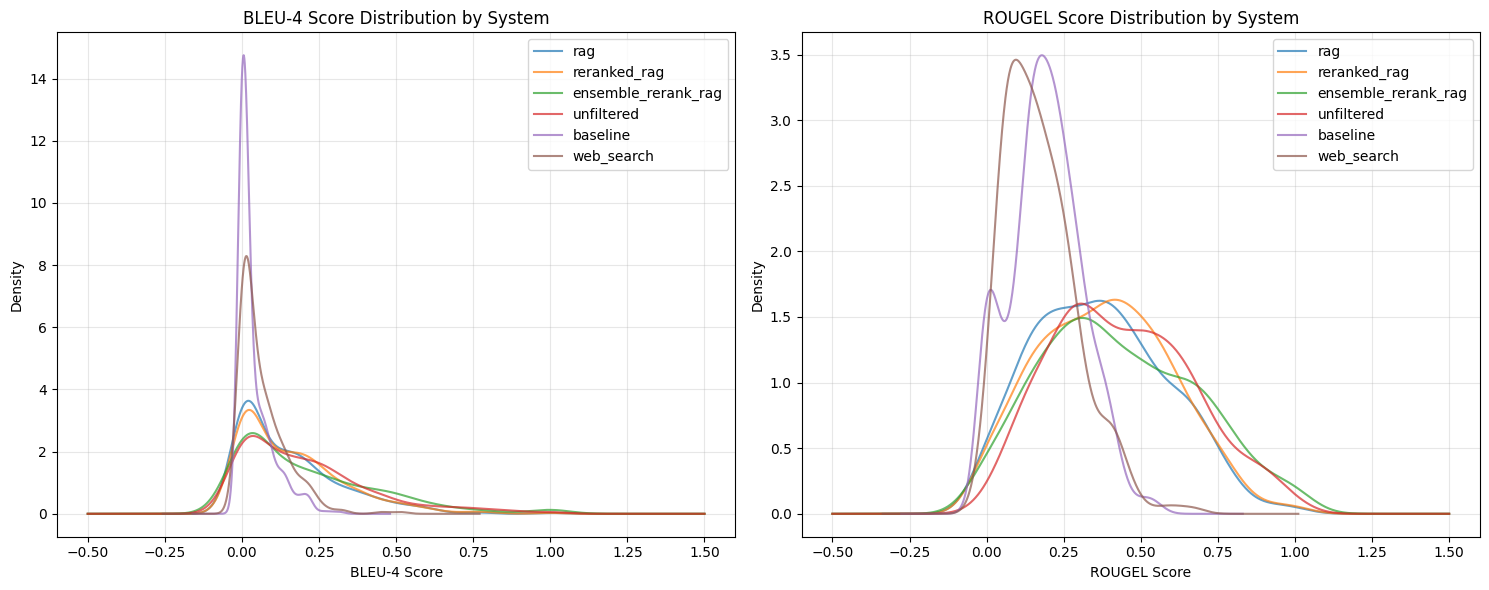

In [2]:
from eval_utils import plot_distributions
plot_distributions(df)

Our ROUGE-L scores are quite good, especially in comparison to other finance QA systems. [Chen et al 2024](https://aclanthology.org/2024.acl-long.328.pdf) reported RougeL scores in the 20s, but their corpus was much bigger than ours. 

BLEU-4 has a consistently low score, especially for the web and baseline systems.  
However, this isn't necessarily a red flag in the finance domain. In financial QA,  
we're more interested in whether the answer contains the correct facts (e.g., entities, figures, dates)  
than whether it uses the exact phrasing of the ground truth.

For example, consider this ground truth:

> Apple has a market cap of $2.2 trillion.


**Answer 1:** Tesla has a market cap of $2.2 billion.  
**Answer 2:** As of 2024, Apple's $2.2 trillion market cap overshadows all other tech companies.

Answer 1 might score deceptively high on BLEU-4 because it overlaps lexically with the reference,  
even though it's factually incorrect (wrong company and amount).

Answer 2 might score relatively low on BLEU-4 due to phrasing differences,  
but high on ROUGE-L because it preserves key factual content in a paraphrased form.

In domains like legal or customer service QA, where exact wording can be critical,  
a low BLEU-4 would be more concerning.

In our case, we treat ROUGE-L as a more reliable indicator of factual correctness,  
and interpret BLEU-4 as a secondary signal for surface-level fluency.

Based on a cursory overview of the responses, the generated answers were typically much more verbose than the ground truth, which could explain the lower BLEU scores but the decent ROUGE-L scores. 

The distribution of ROUGE-L of the more accurate systems seems to center at 0.35. Let's check ROUGE-L scores about 0.35 to make sure that they're generally correct. 

In [3]:
from eval_utils import show_sample_questions
show_sample_questions(df, n=5)

Sample of 5 questions with ROUGE-L > 0.35:
Question: What was the cumulative total return comparison for Facebook, Inc. for the fiscal year ended December 31, 2020?
Ground Truth: The cumulative total return comparison for Facebook, Inc. was shown against the DJINET, S&P 500, and Nasdaq Composite for the five years ended December 31, 2020.
Generated Answer: I don't have access to specific figures or detailed cumulative total return comparisons for Facebook, Inc. (now known as Meta Platforms, Inc.) for the fiscal year ended December 31, 2020. However, typically, companies include this information in their annual reports (10-K filings) or proxy statements
Method: baseline
ROUGE-L Score: 0.378
--------------------------------------------------------------------------------
Question: What assurance does the company's internal control over financial reporting provide regarding transactions in the fiscal year?
Ground Truth: It provides reasonable assurance that transactions are recorded as ne

I checked around 100 questions with a ROUGE-L score between 0.35-0.4, and I'd say about 95% of the answers are factually accurate. 

There are other methods that we could use to gauge whether or not it's factually accurate. LLM's as a judge is one option, or using BERTScore. However most papers evaluating Q&A tasks tend to focus on recall heavy metrics. Recall is more important for our use case because a false negative cost is much higher than a false positive cost. Regulators care much more about ommitted facts than extra information. 

For the purposes of this exercise, we'll count any question with a ROUGE-L score of >=0.35 as correct. 

In [4]:
df['is_accurate'] = df['rougeL'] >= 0.35

Now, which systems are most accurate?

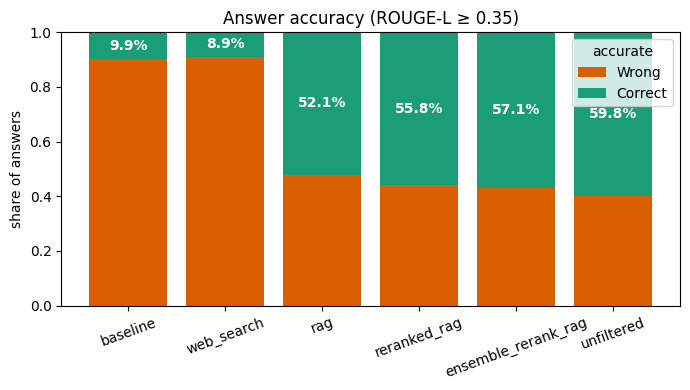

In [5]:
from eval_utils import plot_accuracy_bars
plot_accuracy_bars(df)

The reranked ensemble method performs almost as well as uploading the corresponding SEC file. 

Now let's evaluate the cost per accurate question

In [6]:
from eval_utils import calculate_cost_analysis
# Calculate and display cost analysis tables
cost_analysis = calculate_cost_analysis(df)

print("Cost per 1,000 Accurate Answers by System:")
print("=" * 50)
for system in cost_analysis.index:
    cost_per_1k_accurate = cost_analysis.loc[system, 'cost_per_1k_accurate']
    accuracy_rate = cost_analysis.loc[system, 'accuracy_rate']
    print(f"{system:20} ${cost_per_1k_accurate:8.2f} (accuracy: {accuracy_rate:.1%})")

print("\n" + "=" * 50)
print("Cost per 1,000 Queries by System:")
print("=" * 50)
for system in cost_analysis.index:
    avg_cost_per_question = cost_analysis.loc[system, 'avg_cost_per_question']
    cost_per_1k_queries = avg_cost_per_question * 1000
    print(f"{system:20} ${cost_per_1k_queries:8.2f}")

print("\n" + "=" * 50)


Cost per 1,000 Accurate Answers by System:
baseline             $    1.01 (accuracy: 9.9%)
ensemble_rerank_rag  $    0.35 (accuracy: 57.1%)
rag                  $    0.38 (accuracy: 52.1%)
reranked_rag         $    0.36 (accuracy: 55.8%)
unfiltered           $   13.22 (accuracy: 59.8%)
web_search           $  311.16 (accuracy: 8.9%)

Cost per 1,000 Queries by System:
baseline             $    0.10
ensemble_rerank_rag  $    0.20
rag                  $    0.20
reranked_rag         $    0.20
unfiltered           $    7.90
web_search           $   27.60



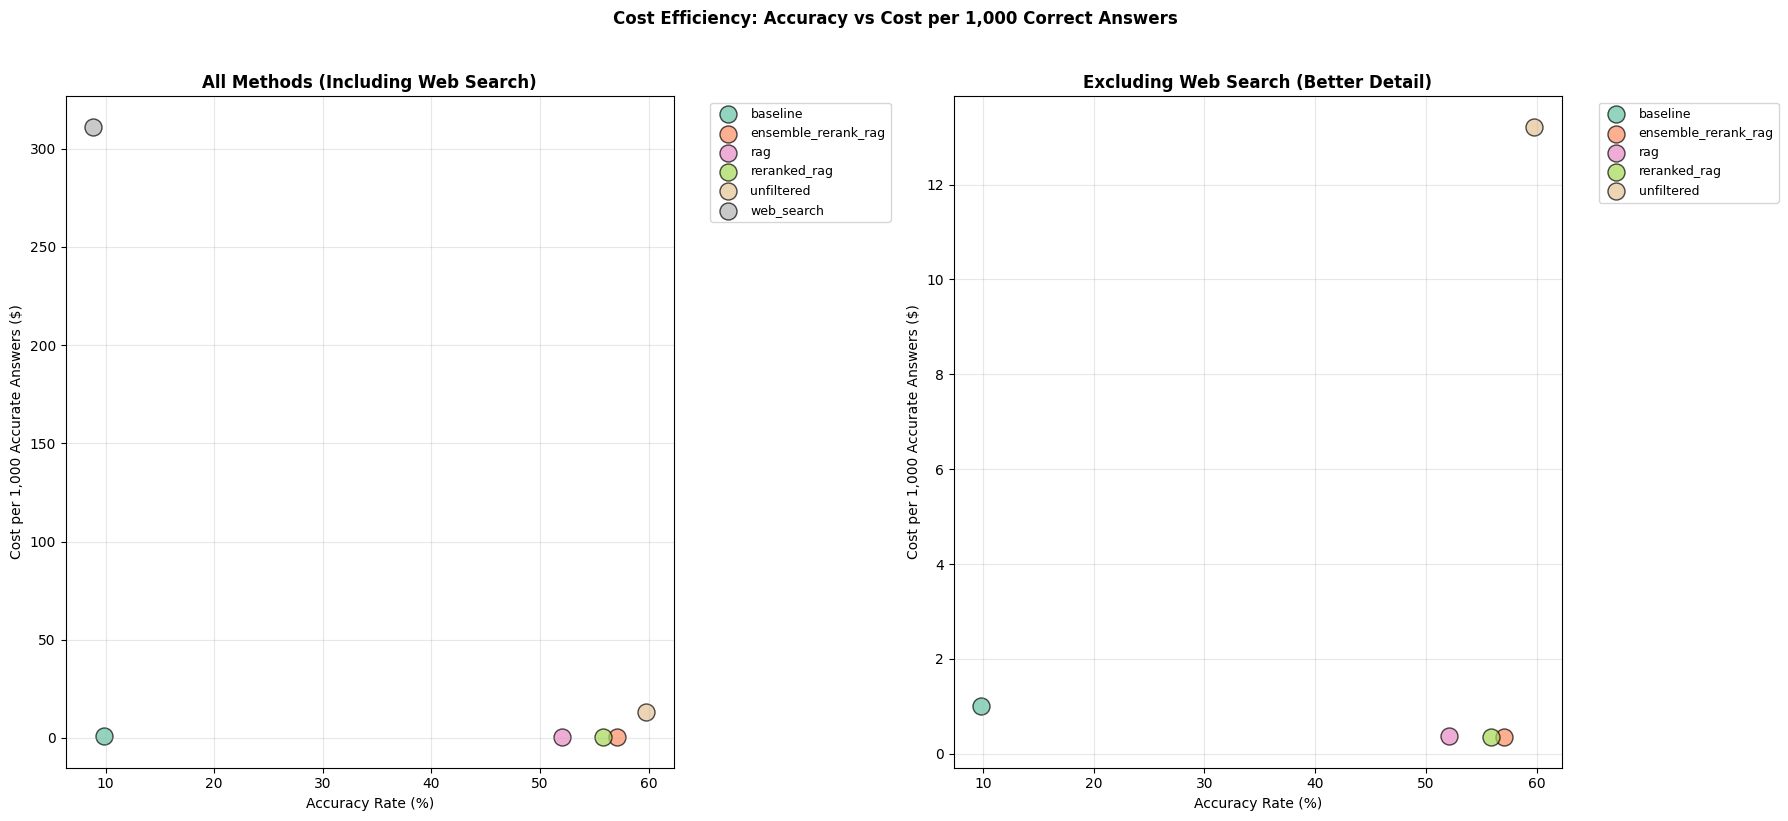

In [7]:
from eval_utils import calculate_cost_analysis, plot_cost_scatter
cost_analysis = calculate_cost_analysis(df)
plot_cost_scatter(cost_analysis)

Our primary metric is Cost Per Accurate Answer, because we want to capture the tradeoff between accuracy and cost. In a real world scenario we'd also want to consider latency, but for the purposes of this exercise we'll assume that's not a factor. 

We can see that the web search is an extreme outlier, costing $300 per correct answer. This is a function of its abysmal performance in getting accurate answers, as well as its per-call cost of $27.5 per 1000 calls, in addition to any token costs. 

The unfiltered model (uploading all context for a specific SEC filing to the LLM) is the most accurate model by a small margin, but costs about 40x more than the RAG models. 

One key component of RAG models that make it an attractive architecture from the business standpoint is its potential for optimization. Currently we are sending the top 10 relevant chunks to the user's query to the LLM. But we set the number of chunks relatively arbitrarily. Let's see if there is room for optimization there to save more costs. 

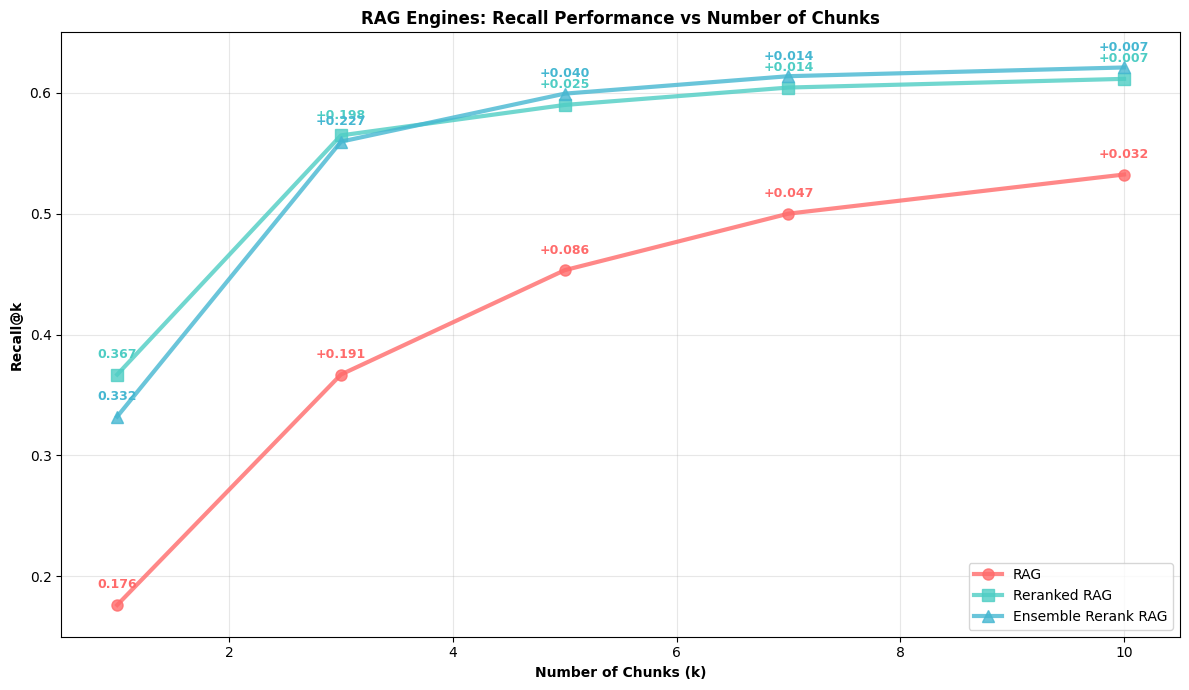

In [8]:
from eval_utils import plot_recall_performance
plot_recall_performance(df)


Looks to be flattening out, let's verify by making sure it's an exponential model. 

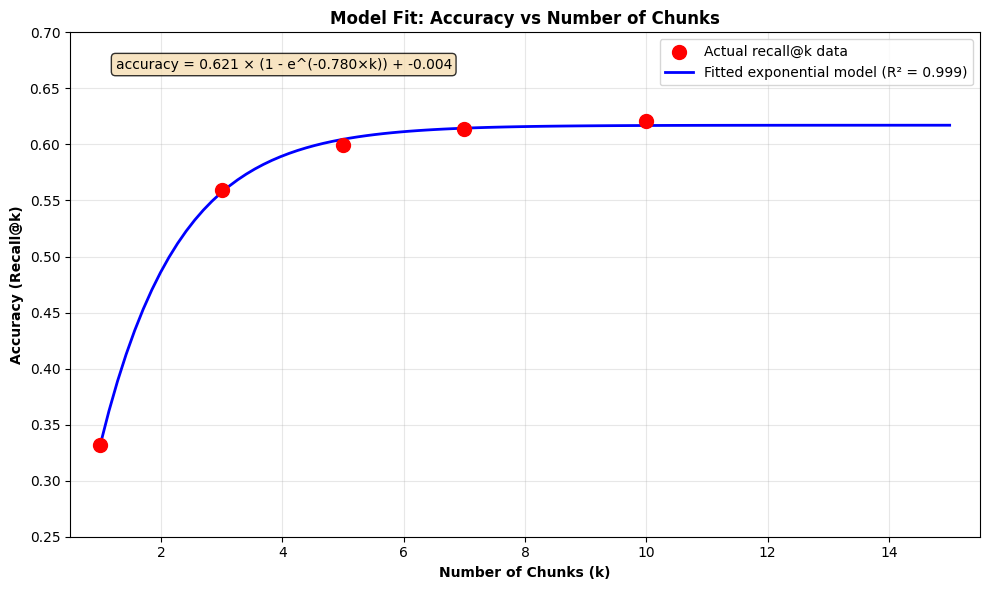

In [9]:
from eval_utils import fit_exponential_model, pareto_analysis
model, params = fit_exponential_model(df)

In [10]:
(df[df['system']
    .isin(['ensemble_rerank_rag', 'rag', 'reranked_rag'])]
    .groupby('system')['ndcg@10']
    .mean()
)

system
ensemble_rerank_rag    0.490832
rag                    0.347270
reranked_rag           0.503573
Name: ndcg@10, dtype: float64

Recall@k means of the top k chunks returned, how many of them were relevant. The more chunks we send, the higher the probability that the chunks we provide will be relevant. But as with any exponential function, it comes with diminishing returns. As we can see here, the delta between 5 and 10 is just 0.022, or about 3.5%. 

Recall our hypothetical user base:
- 1000 users
- Each online for 10 hours per day
- Each asks one question every 3 minutes

That's 200,000 questions per day. 

Every 1 million tokens we send to GPT are $0.15. Each chunk we send has 1500 context tokens. 

If we could cut the number of context tokens in half our savings would be:

In [11]:
users = 1000
active_hours = 10
questions_per_hour = 20

questions_per_year = users * active_hours * questions_per_hour * 365

tokens_per_chunk = 150  
cost_per_million_tokens = 0.15 

current_chunk_number = 10
reduced_chunk_number = 5

current_annual_context_tokens = current_chunk_number * tokens_per_chunk * questions_per_year
reduced_annual_context_tokens = reduced_chunk_number * tokens_per_chunk * questions_per_year

current_annual_context_token_cost = (current_annual_context_tokens / 1_000_000) * cost_per_million_tokens
reduced_annual_context_token_cost = (reduced_annual_context_tokens / 1_000_000) * cost_per_million_tokens

print(f"Questions per year: {questions_per_year:,}")
print(f"Current annual context tokens: {current_annual_context_tokens:,}")
print(f"Current annual operating cost: {df[df['system'] == 'ensemble_rerank_rag']['cost'].mean()*questions_per_year:,.2f}")
print(f"Theoretical annual savings: ${current_annual_context_token_cost - reduced_annual_context_token_cost:,.2f}")


Questions per year: 73,000,000
Current annual context tokens: 109,500,000,000
Current annual operating cost: 13,932.80
Theoretical annual savings: $8,212.50


We could save up to 8k by simply tuning a model parameter with minimal loss to accuracy. 

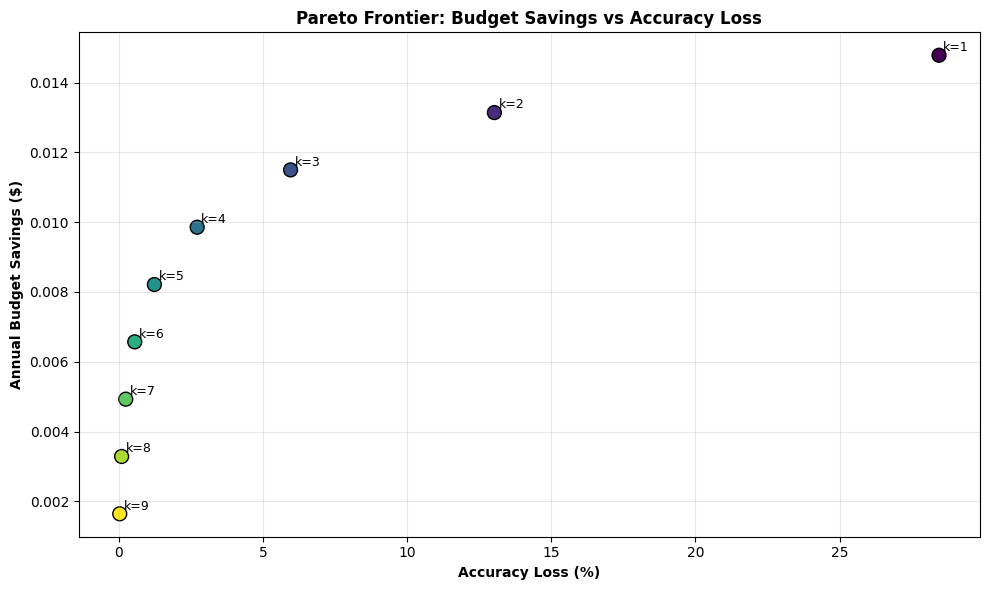

In [12]:
pareto_analysis(df, model, params)

We optimize for both cost and accuracy at k=7. However, this model is just our MVP. We can optimize other parts of the architecture for more savings to build a more scaleable system. For more information see Next Steps in the README.md file. 

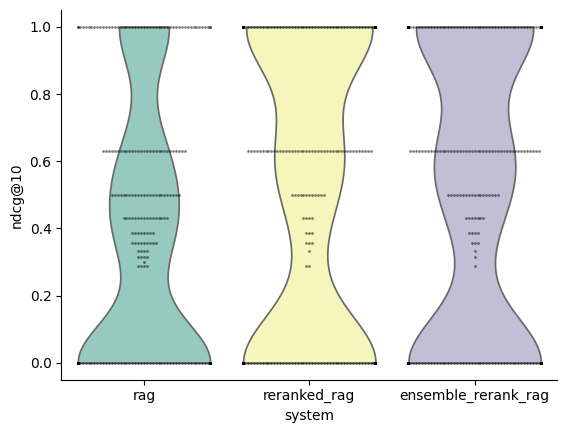

In [13]:
import seaborn as sns, pandas as pd

sns.violinplot(
    data=df[df['system'].isin(['ensemble_rerank_rag', 'rag', 'reranked_rag'])], x="system", y="ndcg@10", inner=None, cut=0, palette="Set3"
)
sns.swarmplot(
    data=df[df['system'].isin(['ensemble_rerank_rag', 'rag', 'reranked_rag'])], x="system", y="ndcg@10", color="k", size=2, alpha=.5
)
sns.despine()

This is slightly on the lower side, the 2nd place winners at the [ICAIF 2024 FinanceRAG hackathon](https://arxiv.org/pdf/2411.16732) had a ndgc@10 of about 0.63. This could be due to the embeddings we used (the small model rather than large model) or using the small reranker model.